# Model hyperparameter tuning with nested cross-validation

This notebook shows how I have implemented a nested cross validation approach for tunining regularized regression model hyperparameters on a toy dataset.

The data are simulated, but were scaled to resemble the inputs of a mammalian epigenetic clock model I previously worked on.

## Setup

In [13]:
## Import public python packages
import os
import sys
from typing import Any, TypedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model._base import LinearModel
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, LeaveOneGroupOut
from sklearn.datasets import make_regression

## Import local python package with custom functions
module_path = '~/Desktop/python_nested_cv'
if module_path not in sys.path:
    sys.path.append(module_path)
from nested_CV_funcs import nested_CV

## Set local constants
N_SAMPLES = 500
N_MODEL_FEATURES = 1000
N_INFORMATIVE_FEATURES = 50
N_OUTER_FOLDS = 10
N_INNER_FOLDS = 5

## Generate a toy dataset

In [14]:
## Generate a small fake dataset with n_samples individuals and n_features features, n_informative of which are informative
features, repsonse = make_regression(
    n_samples=N_SAMPLES,
    n_features=N_MODEL_FEATURES,
    n_informative=N_INFORMATIVE_FEATURES,
    noise=1.0,
    random_state=23,
)

##  Scale features (CpG site methylation levels) to range 0..1, response variable (age in days) to range 0..8000
feature_df = pd.DataFrame(np.interp(features, (features.min(), features.max()), (0, 1)))
feature_df.columns = feature_df.add_prefix('CpG_').columns
print("Feature dataframe:")
display(feature_df.head())
response_df = pd.DataFrame({"true_age": np.interp(repsonse, (repsonse.min(), repsonse.max()), (0, 8000))})
print("Response dataframe:")
display(response_df.head())

## Split data into training (75%) and test (25%) subsets and store train/test designations in a new metadata table
metadata_df = pd.DataFrame({"sample_id": feature_df.index})
train_indices, test_indices = train_test_split(np.arange(feature_df.shape[0]), test_size=0.25)
print(f"Num. training samples: {len(train_indices)}, Num. test samples: {len(test_indices)}")
metadata_df["study_subset"] = metadata_df["sample_id"].apply(lambda x: "test" if x in test_indices else "train")

## Divide the training dataset into equal sized groups (i.e. the outer folds)
n_outer_folds = N_OUTER_FOLDS
OF_kf = KFold(n_splits=n_outer_folds, shuffle=False)
metadata_df["outer_fold"] = -1

for outer_fold, (OF_train_indices, OF_test_indices) in enumerate(OF_kf.split(metadata_df.loc[train_indices, "sample_id"])):
    OF_test_sample_ids = metadata_df.loc[train_indices[OF_test_indices], "sample_id"]
    OF_train_sample_ids = metadata_df.loc[train_indices[OF_train_indices], "sample_id"]
    metadata_df.loc[OF_test_sample_ids, "outer_fold"] = outer_fold

print("Sample metadata dataframe:")
display(metadata_df.sort_values(by=["study_subset", "outer_fold"]))
print(f"Num. samples per outer fold: {metadata_df['outer_fold'].value_counts()}")

Feature dataframe:


,CpG_0,CpG_1,CpG_2,CpG_3,CpG_4,CpG_5,CpG_6,CpG_7,CpG_8,CpG_9,...,CpG_990,CpG_991,CpG_992,CpG_993,CpG_994,CpG_995,CpG_996,CpG_997,CpG_998,CpG_999
0,0.578835,0.551357,0.654822,0.503346,0.603198,0.568457,0.511940,0.472049,0.386675,0.593329,...,0.437922,0.604572,0.382936,0.445798,0.326207,0.435543,0.662047,0.449376,0.548280,0.567373
1,0.645428,0.401634,0.490545,0.558800,0.557590,0.343361,0.573901,0.628010,0.556599,0.463594,...,0.299772,0.368136,0.223684,0.591766,0.503496,0.375656,0.421757,0.382717,0.568355,0.657432
2,0.635189,0.423911,0.476222,0.461931,0.359563,0.499467,0.553733,0.775532,0.360406,0.471656,...,0.506251,0.388164,0.533154,0.393360,0.529081,0.603788,0.387103,0.513386,0.549785,0.430742
3,0.486470,0.453559,0.487418,0.426321,0.529160,0.584010,0.388550,0.510366,0.515420,0.437200,...,0.588827,0.518388,0.495294,0.294678,0.303385,0.490427,0.428710,0.379833,0.692243,0.438015
4,0.669383,0.507999,0.371126,0.594956,0.459087,0.425742,0.418600,0.448705,0.359780,0.234913,...,0.663815,0.316358,0.514996,0.684151,0.478498,0.458303,0.638043,0.821408,0.460977,0.397326


Response dataframe:


,true_age
0,4933.272996
1,5379.986436
2,5916.038216
3,6527.388941
4,4232.782618


Num. training samples: 375, Num. test samples: 125
Sample metadata dataframe:


,sample_id,study_subset,outer_fold
3,3,test,-1
5,5,test,-1
8,8,test,-1
13,13,test,-1
15,15,test,-1
...,...,...,...
471,471,train,9
477,477,train,9
479,479,train,9
486,486,train,9


Num. samples per outer fold: outer_fold
-1    125
 4     38
 3     38
 2     38
 1     38
 0     38
 6     37
 7     37
 9     37
 5     37
 8     37
Name: count, dtype: int64


## Perform nested cross validation for 3 methods
Loop over outer folds, and for each outer fold, perform a grid search over the hyperparameter space using the inner folds. Then evaluate the performance of the best model on the outer fold.

In [15]:
## Define hyperparameter space to explore for 3 regularized regression methods
class MethodDict(TypedDict):
    estimator: LinearModel
    param_grid: dict[str, Any]

method_dicts = {
    "Ridge": MethodDict(
        estimator=Ridge(tol=0.001),
        param_grid={"alpha": np.logspace(-5, 1, 20)},
    ),
    "Lasso": MethodDict(
        estimator=Lasso(tol=0.001),
        param_grid={"alpha": np.logspace(-5, 1, 20)},
    ),
    "ElasticNet": MethodDict(
        estimator=ElasticNet(tol=0.01),
        param_grid={
            "alpha": np.logspace(-5, 1, 20),
            "l1_ratio": [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95],
        },
    ),
}

### Hyperparameter tuning with inner fold cross validation
This analysis gives us important insights about how well each method captures the relationship between the independent variables and the response variable in our dataset, all without ever touching the holdout test set that should be used get the final performance metrics after this step.

If a method generalizes well in nested cross validation, we should see that the best hyperparameter set is pretty consistent across outer folds

If this were a real dataset, the consistency of the inner-fold average errors and error ranges could also give us an idea of how well we designed the folds: ideally, they should have highly similar error metrics. If they do not, we would want to consider trying to make them more balanced using something like the approach implemented in the [`iterative-stratification`](https://pypi.org/project/iterative-stratification/) `MultilabelStratifiedKFold` function.

In [16]:
## Format train and test data for nested-cv functions
_mask = metadata_df["study_subset"] == "train"
_X = feature_df.loc[_mask, :]
_y = response_df.loc[_mask, "true_age"]
_groups = metadata_df.loc[_mask, "outer_fold"]
print(
    f"Training data: _X.shape = {_X.shape}, _y.shape = {_y.shape}, _groups = {_groups.unique()}"
)

_holdout_mask = metadata_df["study_subset"] == "test"
_X_holdout = feature_df.loc[_holdout_mask, :]
_y_holdout = response_df.loc[_holdout_mask, "true_age"]
print(
    f"Test data: _X_holdout.shape = {_X_holdout.shape}, _y_holdout.shape = {_y_holdout.shape}"
)

inner_cv_results = {}

## Perform hyperparameter tuning with inner fold cross-validation on the training data
for method_name, method_dict in method_dicts.items():
    print(f"Running nested CV on training data with {method_name}")
    _outer_results, _inner_results  = nested_CV.hyperparameter_tuning(
        method_dict=method_dict,
        _X=_X,
        _y=_y,
        outer_fold_groups=_groups,
        _n_inner_folds=N_INNER_FOLDS,
    )
    display(_outer_results)
    inner_cv_results[method_name] = _inner_results


Training data: _X.shape = (375, 1000), _y.shape = (375,), _groups = [4 3 2 6 1 0 7 9 5 8]
Test data: _X_holdout.shape = (125, 1000), _y_holdout.shape = (125,)
Running nested CV on training data with Ridge


  0%|          | 0/10 [00:00<?, ?it/s]

,outer_fold,best_params,rmse
0,1,{'alpha': 1.1288378916846884},33.805250
1,2,{'alpha': 0.5455594781168515},34.859056
2,3,{'alpha': 2.3357214690901213},37.964993
3,4,{'alpha': 0.1274274985703132},34.836672
4,5,{'alpha': 2.3357214690901213},37.662999
5,6,{'alpha': 0.26366508987303555},38.055515
6,7,{'alpha': 1.1288378916846884},30.706574
7,8,{'alpha': 2.3357214690901213},36.571945
8,9,{'alpha': 1.1288378916846884},31.648191
9,10,{'alpha': 0.5455594781168515},36.464143


Running nested CV on training data with Lasso


  0%|          | 0/10 [00:00<?, ?it/s]

,outer_fold,best_params,rmse
0,1,{'alpha': 0.1274274985703132},0.447129
1,2,{'alpha': 0.1274274985703132},0.469623
2,3,{'alpha': 0.1274274985703132},0.388971
3,4,{'alpha': 0.06158482110660261},0.298583
4,5,{'alpha': 0.1274274985703132},0.408392
5,6,{'alpha': 0.1274274985703132},0.488362
6,7,{'alpha': 0.06158482110660261},0.225475
7,8,{'alpha': 0.06158482110660261},0.234727
8,9,{'alpha': 0.06158482110660261},0.262927
9,10,{'alpha': 0.1274274985703132},0.540990


Running nested CV on training data with ElasticNet


  0%|          | 0/10 [00:00<?, ?it/s]

,outer_fold,best_params,rmse
0,1,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",33.019098
1,2,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",34.460717
2,3,"{'alpha': 0.1274274985703132, 'l1_ratio': 0.95}",37.206366
3,4,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",34.191617
4,5,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",36.637906
5,6,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",37.278836
6,7,"{'alpha': 0.06158482110660261, 'l1_ratio': 0.95}",30.142534
7,8,"{'alpha': 0.1274274985703132, 'l1_ratio': 0.95}",35.972171
8,9,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",31.048839
9,10,"{'alpha': 0.029763514416313162, 'l1_ratio': 0.95}",36.052706


/var/folders/dn/z15rr32j4l3g9zc1k7tc55h40000gn/T/ipykernel_58354/3058221298.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, size=10)


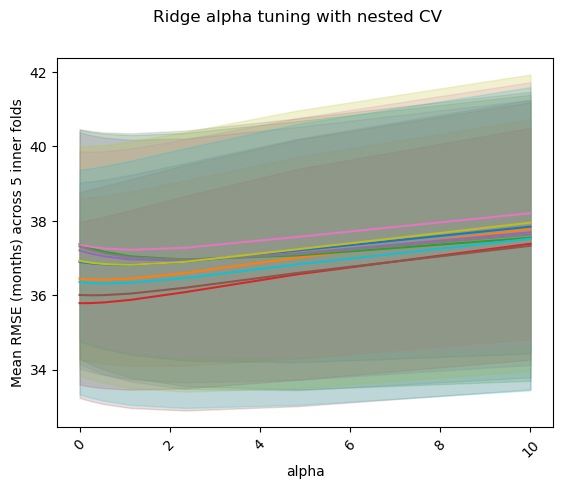

/var/folders/dn/z15rr32j4l3g9zc1k7tc55h40000gn/T/ipykernel_58354/3058221298.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, size=10)


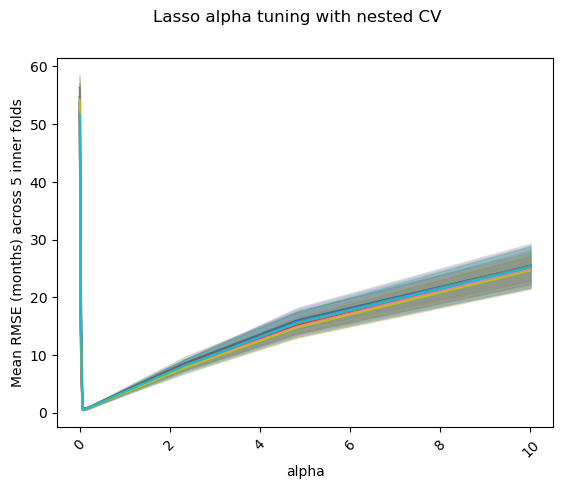

/var/folders/dn/z15rr32j4l3g9zc1k7tc55h40000gn/T/ipykernel_58354/3058221298.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, size=10)


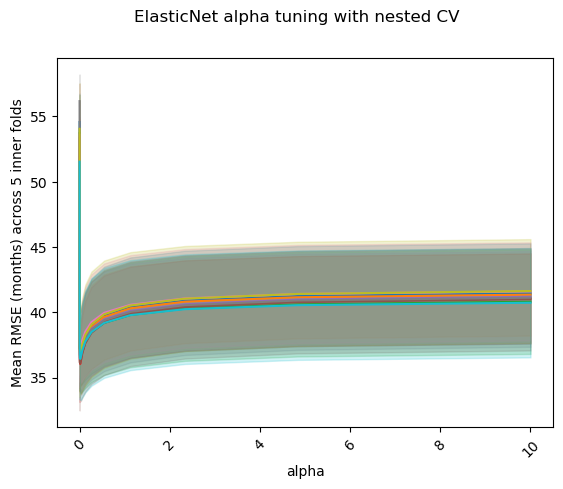

/var/folders/dn/z15rr32j4l3g9zc1k7tc55h40000gn/T/ipykernel_58354/3058221298.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, size=10)


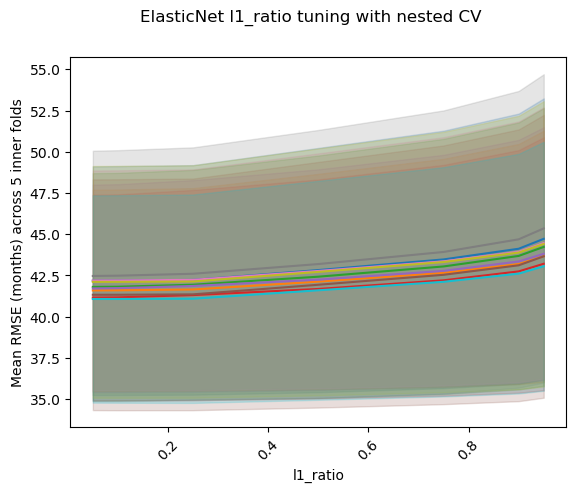

In [17]:
## Plot hyperparameter tuning results
for method_name, method_dict in method_dicts.items():
    inner_fold_df = pd.DataFrame(inner_cv_results[method_name])
    inner_fold_rmse_cols = [f"split{i}_test_neg_root_mean_squared_error" for i in range(0, N_INNER_FOLDS)]
    params = method_dict["param_grid"].keys()
    for param_name in params:
        param_column_name = f"param_{param_name}"
        param_df = pd.melt(
            frame=inner_fold_df[[param_column_name, "outer_fold"] + inner_fold_rmse_cols],
            id_vars=[param_column_name, "outer_fold"],
            value_vars=inner_fold_rmse_cols,
            value_name="inner_fold_neg_rmse",
        ).rename(columns={"outer_fold": "Outer Fold"})
        param_df[f"rounded_{param_name}"] = param_df[param_column_name].round(4)
        param_df[f"log_{param_name}"] = np.log10(param_df[param_column_name]).round(4)
        param_df["abs_RMSE"] = abs(param_df["inner_fold_neg_rmse"]) / nested_CV.DAYS_PER_MONTH
        
        fig, ax = plt.subplots(1, 1)
        x_var = f"rounded_{param_name}"
        x_var_label = param_name
        sns.lineplot(
            data=param_df,
            x=x_var,
            y="abs_RMSE",
            ax=ax,
            hue="Outer Fold",
            palette=sns.color_palette("tab10"),
            errorbar="sd",
            legend=False,
        )
        plt.xlabel(x_var_label) 
        plt.xticks(rotation=45)
        xticks, xlabels = plt.xticks()
        ax.set_xticklabels(xlabels, size=10)
        plt.ylabel("Mean RMSE (months) across 5 inner folds")
        plt.suptitle(f"{method_name} {param_name} tuning with nested CV")
        plt.show()

## Fit models with best hyperparameters on entire training subset, and evaluate on test subset
These are the error metrics that should be used to choose the final model method prior to re-fitting on the entire dataset to get the production model.

Selecting hyperparameters for Ridge on training data
Evaluating Ridge with chosen hyperparameters on test data
Selecting hyperparameters for Lasso on training data
Evaluating Lasso with chosen hyperparameters on test data
Selecting hyperparameters for ElasticNet on training data
Evaluating ElasticNet with chosen hyperparameters on test data


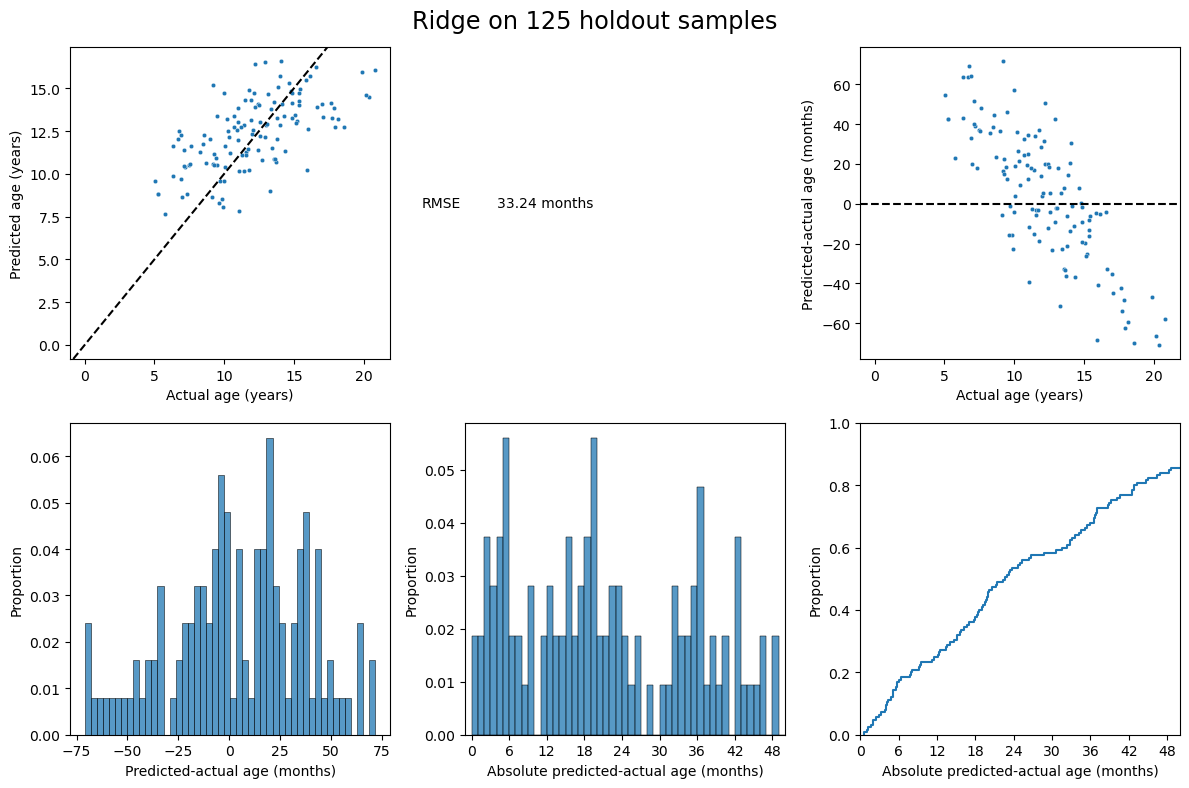

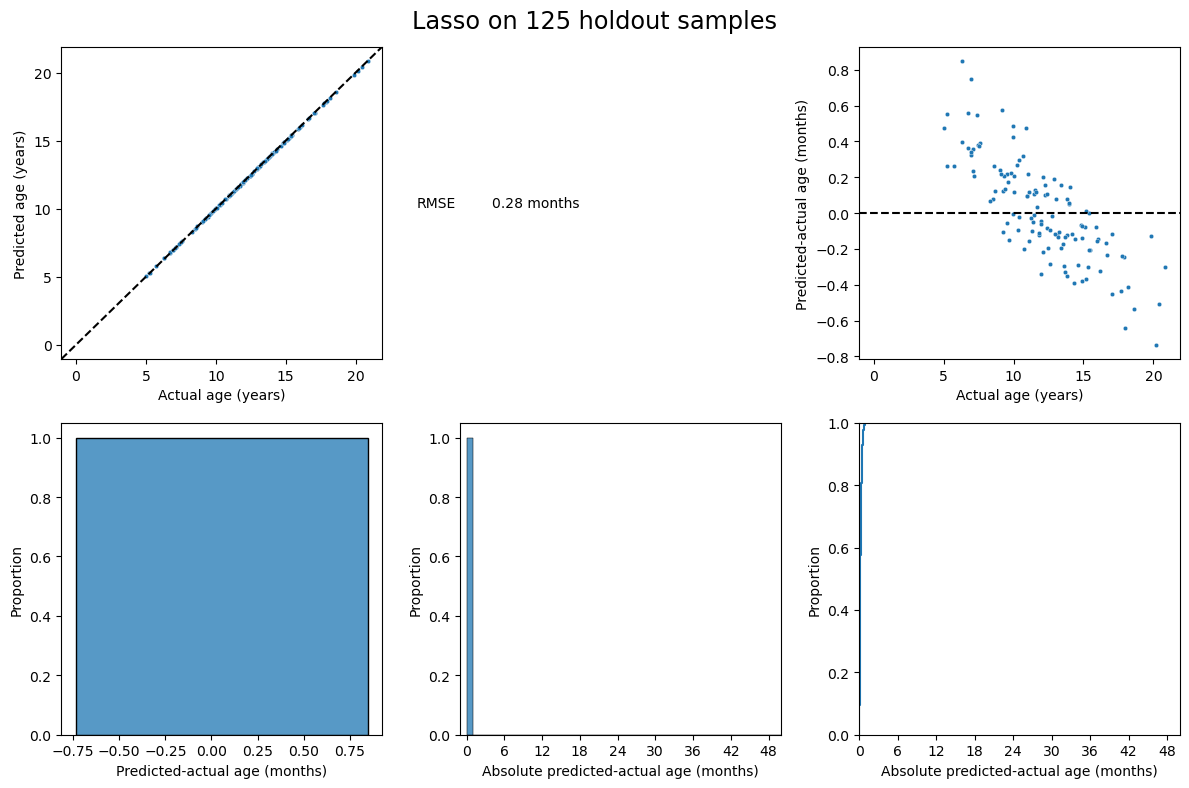

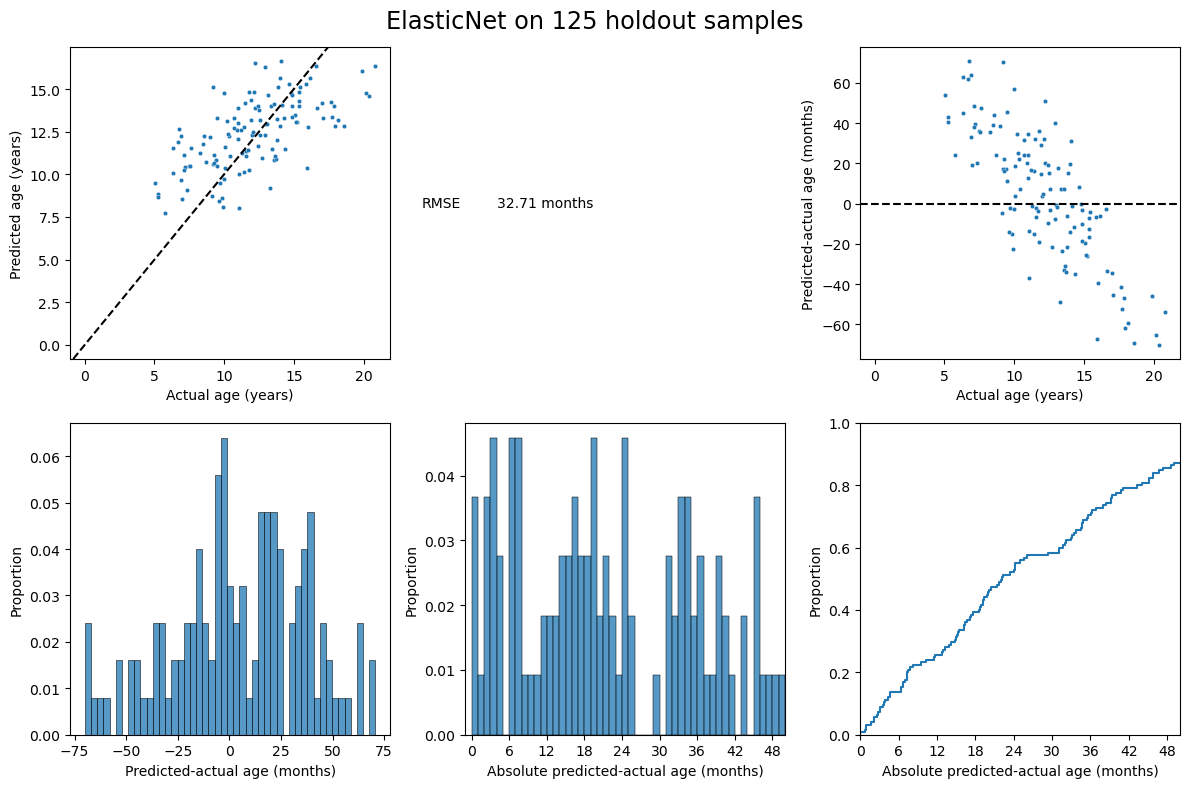

In [18]:
## Use best hyperparameter values per nested CV to fit a model for each
## method and get its 10-fold cross-validated error metrics
(
    model_performance_df,
    residError_by_quantile_df,
    quantile_by_residError_df,
    m_pred
) = nested_CV.tune_test_model(
    _X=_X,
    _y=_y,
    _groups=_groups,
    _X_holdout=_X_holdout,
    _y_holdout=_y_holdout,
    method_dicts=method_dicts,
    n_jobs=-1,
    _generate_plots=True
)